<a href="https://colab.research.google.com/github/MaicolLojano/Mineria-de-Datos/blob/main/UNIDAD2/Clustering_Maicol_Lojano_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

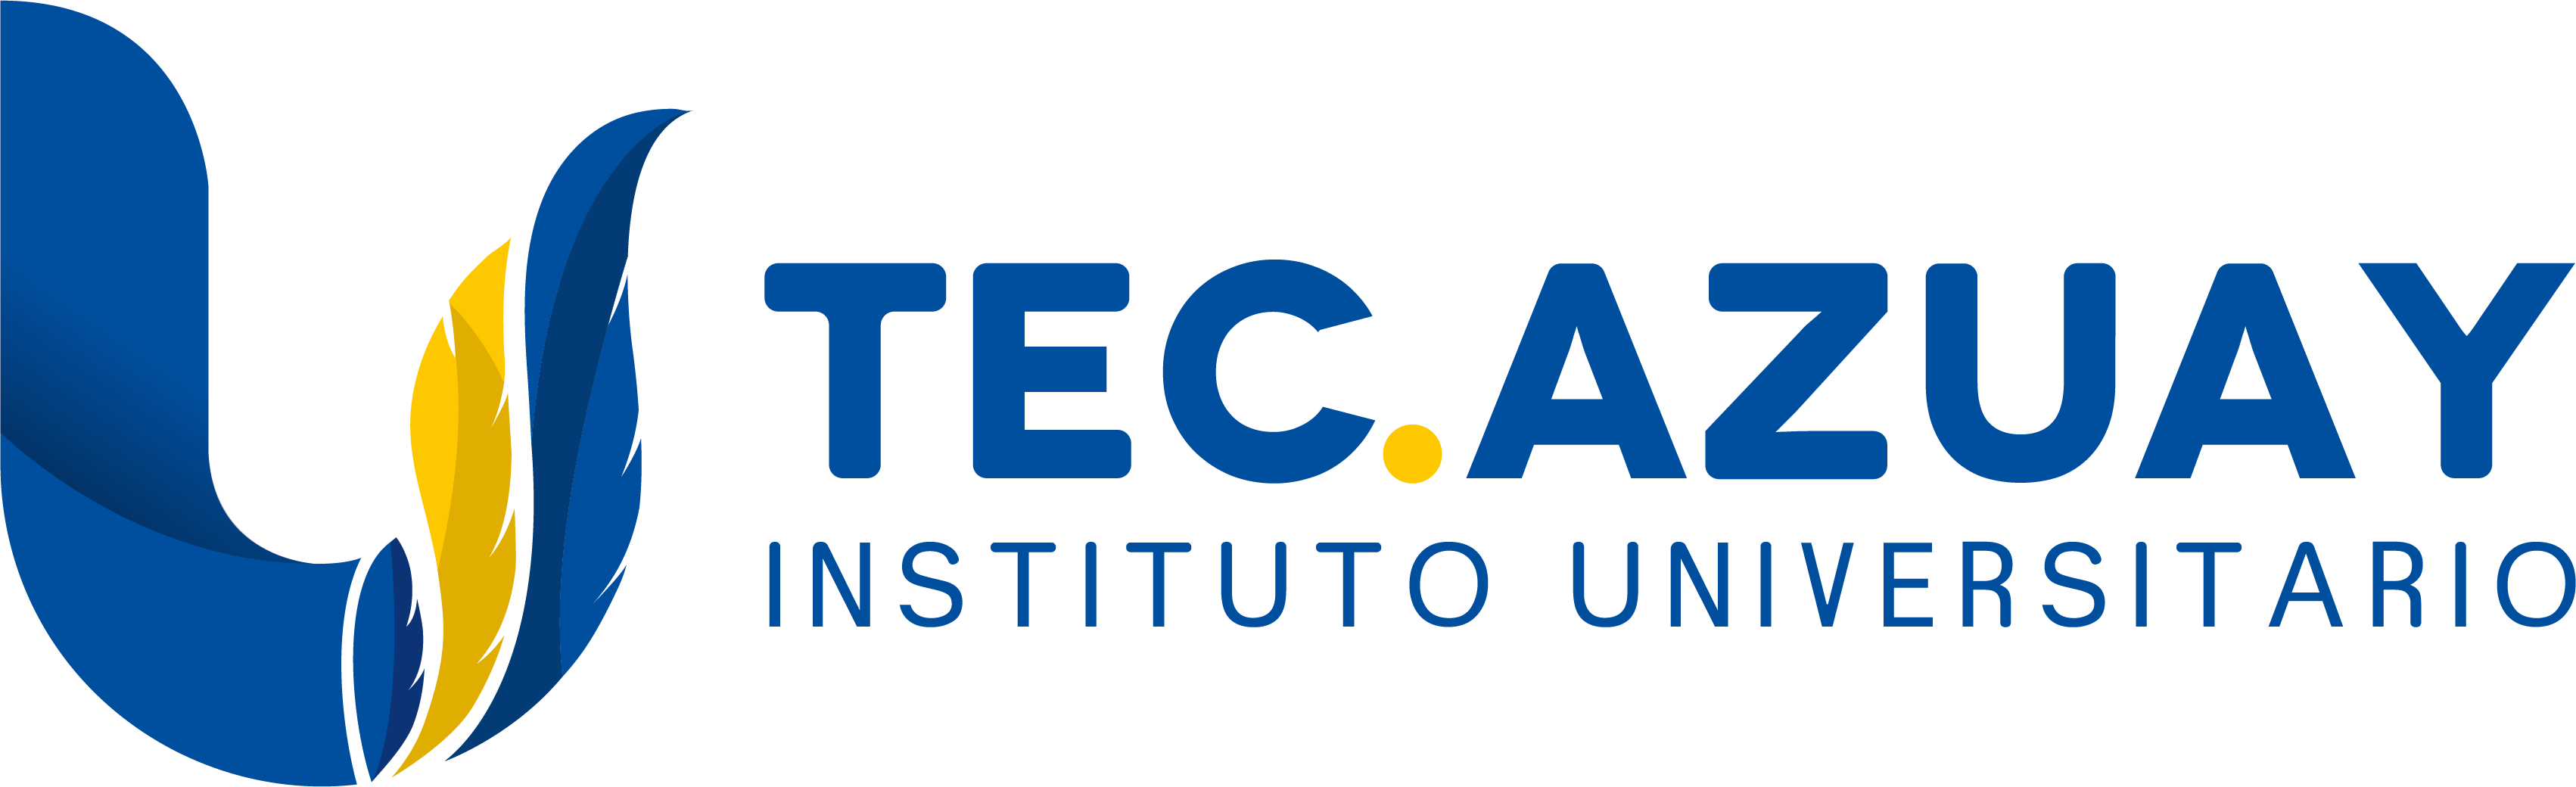

Asignatura: Mineria de datos

Nombre: Maicol Lojano

Docente: Ing. Veronica Chimbo


\# Clustering en el conjunto de datos con pyspark

## 1. Preparar los Datos

Primero, asegúrate de tener las bibliotecas necesarias:

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d8336c2295b52e2da92b8e6ee78720d46177a09cea6d94baa595dd541cb70972
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
# Crear una sesión de Spark
spark = SparkSession.builder.appName("ClusteringExample").getOrCreate()

In [ ]:
# Leer el archivo CSV
df = spark.read.csv('/content/MAESTRO DE NOTAS.csv', header=True, inferSchema=True)


In [ ]:
# Verificar el esquema del DataFrame
df.printSchema()

root
 |-- Periodo: string (nullable = true)
 |-- Paralelo: string (nullable = true)
 |-- Identificacion: long (nullable = true)
 |-- Estudiante: string (nullable = true)
 |-- Carrera: string (nullable = true)
 |-- Nivel: string (nullable = true)
 |-- Asignatura: string (nullable = true)
 |-- Num_matricula: integer (nullable = true)
 |-- _c8: string (nullable = true)
 |-- Asistencia: double (nullable = true)
 |-- Nota final: double (nullable = true)
 |-- Estado: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- Estado Matrícula: string (nullable = true)
 |-- Tipo Ingreso: string (nullable = true)
 |-- Cédula docente: integer (nullable = true)
 |-- Nombre docente: string (nullable = true)



## 2. Preprocesar los Datos

Eliminamos columnas que contienen información sensible, para el proceso de aplicar k-means

In [ ]:
df.columns

['Periodo',
 'Paralelo',
 'Identificacion',
 'Estudiante',
 'Carrera',
 'Nivel',
 'Asignatura',
 'Num_matricula',
 '_c8',
 'Asistencia',
 'Nota final',
 'Estado',
 '_c12',
 'Estado Matrícula',
 'Tipo Ingreso',
 'Cédula docente',
 'Nombre docente']

In [ ]:
# Eliminar múltiples columnas
columns_to_drop = ['Estudiante', 'Identificacion', 'Nombre docente']
df = df.drop(*columns_to_drop)


Verificamos si se eliminaron correctamente las oclumnas, mostrando los nombres de columnas

In [ ]:
# Mostrar el esquema del DataFrame después de eliminar las columnas
df.printSchema()

root
 |-- Periodo: string (nullable = true)
 |-- Paralelo: string (nullable = true)
 |-- Carrera: string (nullable = true)
 |-- Nivel: string (nullable = true)
 |-- Asignatura: string (nullable = true)
 |-- Num_matricula: integer (nullable = true)
 |-- _c8: string (nullable = true)
 |-- Asistencia: double (nullable = true)
 |-- Nota final: double (nullable = true)
 |-- Estado: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- Estado Matrícula: string (nullable = true)
 |-- Tipo Ingreso: string (nullable = true)
 |-- Cédula docente: integer (nullable = true)



In [ ]:
from pyspark.sql.functions import col, sum

# Contar valores nulos por columna
missing_data = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_data.show()


+-------+--------+-------+-----+----------+-------------+----+----------+----------+------+----+----------------+------------+--------------+
|Periodo|Paralelo|Carrera|Nivel|Asignatura|Num_matricula| _c8|Asistencia|Nota final|Estado|_c12|Estado Matrícula|Tipo Ingreso|Cédula docente|
+-------+--------+-------+-----+----------+-------------+----+----------+----------+------+----+----------------+------------+--------------+
|      0|     202|      0|    0|         0|            0|6007|       231|       187|     0|6007|               0|           0|           202|
+-------+--------+-------+-----+----------+-------------+----+----------+----------+------+----+----------------+------------+--------------+



In [ ]:
# Lista de columnas categóricas a convertir
categorical_columns = ['Carrera', 'Nivel', 'Estado', 'Tipo Ingreso']

# Crear un diccionario para almacenar los indexadores
indexers = {}

# Aplicar StringIndexer a cada columna categórica
for column in categorical_columns:
    indexer = StringIndexer(inputCol=column, outputCol=f"{column}_index")
    df = indexer.fit(df).transform(df)
    indexers[column] = indexer

# Mostrar el DataFrame resultante
df.show()

+-------+----------+--------------------+-------+--------------------+-------------+----+----------+----------+--------+----+----------------+------------+--------------+-------------+-----------+------------+------------------+
|Periodo|  Paralelo|             Carrera|  Nivel|          Asignatura|Num_matricula| _c8|Asistencia|Nota final|  Estado|_c12|Estado Matrícula|Tipo Ingreso|Cédula docente|Carrera_index|Nivel_index|Estado_index|Tipo Ingreso_index|
+-------+----------+--------------------+-------+--------------------+-------------+----+----------+----------+--------+----+----------------+------------+--------------+-------------+-----------+------------+------------------+
|2023-2P|A_MATUTINA|SP R-TECNICO SUPE...|PRIMERO|SPR-114-COMUNICAC...|            1|NULL|     93.75|      8.59|APROBADO|NULL|        APROBADO|      NORMAL|     103002036|          0.0|        0.0|         0.0|               0.0|
|2023-2P|A_MATUTINA|SP R-TECNICO SUPE...|PRIMERO|SPR-111-DERECHOS ...|            1|

In [ ]:
# Contar valores nulos por columna
missing_data = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_data.show()


+-------+--------+-------+-----+----------+-------------+----+----------+----------+------+----+----------------+------------+--------------+-------------+-----------+------------+------------------+
|Periodo|Paralelo|Carrera|Nivel|Asignatura|Num_matricula| _c8|Asistencia|Nota final|Estado|_c12|Estado Matrícula|Tipo Ingreso|Cédula docente|Carrera_index|Nivel_index|Estado_index|Tipo Ingreso_index|
+-------+--------+-------+-----+----------+-------------+----+----------+----------+------+----+----------------+------------+--------------+-------------+-----------+------------+------------------+
|      0|     202|      0|    0|         0|            0|6007|       231|       187|     0|6007|               0|           0|           202|            0|          0|           0|                 0|
+-------+--------+-------+-----+----------+-------------+----+----------+----------+------+----+----------------+------------+--------------+-------------+-----------+------------+------------------+


In [ ]:
from pyspark.ml.feature import Imputer

# Imputar valores nulos en las columnas numéricas
imputer = Imputer(inputCols=numeric_features, outputCols=numeric_features)
df = imputer.fit(df).transform(df)

# Convertir las características a tipo double
df = df.select([col(f).cast("double") for f in all_features])

# Ensamblar las características en una sola columna "features"
assembler = VectorAssembler(inputCols=all_features, outputCol="features")
df_assembled = assembler.transform(df)

# Escalar las características
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Mostrar el esquema y algunas filas del DataFrame final
df_scaled.printSchema()
df_scaled.show()


root
 |-- Asistencia: double (nullable = true)
 |-- Nota final: double (nullable = true)
 |-- Carrera_index_index: double (nullable = false)
 |-- Nivel_index_index: double (nullable = false)
 |-- Estado_index_index: double (nullable = false)
 |-- Tipo Ingreso_index_index: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)

+----------+----------+-------------------+-----------------+------------------+------------------------+--------------------+--------------------+
|Asistencia|Nota final|Carrera_index_index|Nivel_index_index|Estado_index_index|Tipo Ingreso_index_index|            features|     scaled_features|
+----------+----------+-------------------+-----------------+------------------+------------------------+--------------------+--------------------+
|     93.75|      8.59|                0.0|              0.0|               0.0|                     0.0|(6,[0,1],[93.75,8...|[0.05540730880654...|
|     100.0|      8.8

In [ ]:
# Contar valores nulos por columna
missing_data = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_data.show()

+----------+----------+-------------------+-----------------+------------------+------------------------+
|Asistencia|Nota final|Carrera_index_index|Nivel_index_index|Estado_index_index|Tipo Ingreso_index_index|
+----------+----------+-------------------+-----------------+------------------+------------------------+
|         0|         0|                  0|                0|                 0|                       0|
+----------+----------+-------------------+-----------------+------------------+------------------------+



Seleccionaremos características relevantes para el clustering y escalaremos los datos:

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.sql.functions import col, mean
from pyspark.ml.feature import StringIndexer


In [ ]:
print(df.columns)


['Asistencia', 'Nota final', 'Carrera_index_index', 'Nivel_index_index', 'Estado_index_index', 'Tipo Ingreso_index_index']


In [ ]:
from pyspark.sql.functions import col

# Columnas numéricas y indexadas
numeric_features = ['Asistencia', 'Nota final']
indexed_features = ['Carrera_index', 'Nivel_index', 'Estado_index', 'Tipo Ingreso_index']

# Crear una lista combinada de todas las características
all_features = numeric_features + indexed_features

# Convertir las características a tipo double
df = df.select([col(f).cast("double") for f in all_features])

# Mostrar el esquema del DataFrame para verificar los cambios
df.printSchema()
df.show()


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `Carrera_index` cannot be resolved. Did you mean one of the following? [`Carrera_index_index`, `Nota final`, `Nivel_index_index`, `Asistencia`, `Estado_index_index`].;
'Project [cast(Asistencia#3171 as double) AS Asistencia#3331, cast(Nota final#3172 as double) AS Nota final#3332, unresolvedalias(cast('Carrera_index as double), None), unresolvedalias(cast('Nivel_index as double), None), unresolvedalias(cast('Estado_index as double), None), unresolvedalias(cast('Tipo Ingreso_index as double), None)]
+- Project [cast(Asistencia#3157 as double) AS Asistencia#3171, cast(Nota final#3158 as double) AS Nota final#3172, cast(Carrera_index_index#3076 as double) AS Carrera_index_index#3173, cast(Nivel_index_index#3077 as double) AS Nivel_index_index#3174, cast(Estado_index_index#3078 as double) AS Estado_index_index#3175, cast(Tipo Ingreso_index_index#3079 as double) AS Tipo Ingreso_index_index#3176]
   +- Project [cast(CASE WHEN isnull(cast(Asistencia#3074 as double)) THEN 92.8184920360111 WHEN (cast(Asistencia#3074 as double) = NaN) THEN 92.8184920360111 ELSE cast(Asistencia#3074 as double) END as double) AS Asistencia#3157, cast(CASE WHEN isnull(cast(Nota final#3075 as double)) THEN 7.817539518900347 WHEN (cast(Nota final#3075 as double) = NaN) THEN 7.817539518900347 ELSE cast(Nota final#3075 as double) END as double) AS Nota final#3158, Carrera_index_index#3076, Nivel_index_index#3077, Estado_index_index#3078, Tipo Ingreso_index_index#3079]
      +- Project [cast(Asistencia#2853 as double) AS Asistencia#3074, cast(Nota final#2854 as double) AS Nota final#3075, cast(Carrera_index_index#2928 as double) AS Carrera_index_index#3076, cast(Nivel_index_index#2971 as double) AS Nivel_index_index#3077, cast(Estado_index_index#3015 as double) AS Estado_index_index#3078, cast(Tipo Ingreso_index_index#3060 as double) AS Tipo Ingreso_index_index#3079]
         +- Project [Asistencia#2853, Nota final#2854, Carrera_index#2855, Nivel_index#2856, Estado_index#2857, Tipo Ingreso_index#2858, Carrera_index_index#2928, Nivel_index_index#2971, Estado_index_index#3015, UDF(cast(Tipo Ingreso_index#2858 as string)) AS Tipo Ingreso_index_index#3060]
            +- Project [Asistencia#2853, Nota final#2854, Carrera_index#2855, Nivel_index#2856, Estado_index#2857, Tipo Ingreso_index#2858, Carrera_index_index#2928, Nivel_index_index#2971, UDF(cast(Estado_index#2857 as string)) AS Estado_index_index#3015]
               +- Project [Asistencia#2853, Nota final#2854, Carrera_index#2855, Nivel_index#2856, Estado_index#2857, Tipo Ingreso_index#2858, Carrera_index_index#2928, UDF(cast(Nivel_index#2856 as string)) AS Nivel_index_index#2971]
                  +- Project [Asistencia#2853, Nota final#2854, Carrera_index#2855, Nivel_index#2856, Estado_index#2857, Tipo Ingreso_index#2858, UDF(cast(Carrera_index#2855 as string)) AS Carrera_index_index#2928]
                     +- Project [cast(Asistencia#2156 as double) AS Asistencia#2853, cast(Nota final#2157 as double) AS Nota final#2854, cast(Carrera_index#2395 as double) AS Carrera_index#2855, cast(Nivel_index#2444 as double) AS Nivel_index#2856, cast(Estado_index#2494 as double) AS Estado_index#2857, cast(Tipo Ingreso_index#2545 as double) AS Tipo Ingreso_index#2858]
                        +- Project [Periodo#2147, Paralelo#2148, Carrera#2151, Nivel#2152, Asignatura#2153, Num_matricula#2154, _c8#2155, Asistencia#2156, Nota final#2157, Estado#2158, _c12#2159, Estado Matrícula#2160, Tipo Ingreso#2161, Cédula docente#2162, Carrera_index#2395, Nivel_index#2444, Estado_index#2494, UDF(cast(Tipo Ingreso#2161 as string)) AS Tipo Ingreso_index#2545]
                           +- Project [Periodo#2147, Paralelo#2148, Carrera#2151, Nivel#2152, Asignatura#2153, Num_matricula#2154, _c8#2155, Asistencia#2156, Nota final#2157, Estado#2158, _c12#2159, Estado Matrícula#2160, Tipo Ingreso#2161, Cédula docente#2162, Carrera_index#2395, Nivel_index#2444, UDF(cast(Estado#2158 as string)) AS Estado_index#2494]
                              +- Project [Periodo#2147, Paralelo#2148, Carrera#2151, Nivel#2152, Asignatura#2153, Num_matricula#2154, _c8#2155, Asistencia#2156, Nota final#2157, Estado#2158, _c12#2159, Estado Matrícula#2160, Tipo Ingreso#2161, Cédula docente#2162, Carrera_index#2395, UDF(cast(Nivel#2152 as string)) AS Nivel_index#2444]
                                 +- Project [Periodo#2147, Paralelo#2148, Carrera#2151, Nivel#2152, Asignatura#2153, Num_matricula#2154, _c8#2155, Asistencia#2156, Nota final#2157, Estado#2158, _c12#2159, Estado Matrícula#2160, Tipo Ingreso#2161, Cédula docente#2162, UDF(cast(Carrera#2151 as string)) AS Carrera_index#2395]
                                    +- Project [Periodo#2147, Paralelo#2148, Carrera#2151, Nivel#2152, Asignatura#2153, Num_matricula#2154, _c8#2155, Asistencia#2156, Nota final#2157, Estado#2158, _c12#2159, Estado Matrícula#2160, Tipo Ingreso#2161, Cédula docente#2162]
                                       +- Relation [Periodo#2147,Paralelo#2148,Identificacion#2149L,Estudiante#2150,Carrera#2151,Nivel#2152,Asignatura#2153,Num_matricula#2154,_c8#2155,Asistencia#2156,Nota final#2157,Estado#2158,_c12#2159,Estado Matrícula#2160,Tipo Ingreso#2161,Cédula docente#2162,Nombre docente#2163] csv


In [ ]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# Definir las columnas categóricas y numéricas
categorical_features = ['Carrera_index', 'Nivel_index', 'Estado_index', 'Tipo Ingreso_index']
numeric_features = ['Asistencia', 'Nota final']

# Codificar las columnas categóricas usando StringIndexer
indexers = [StringIndexer(inputCol=feature, outputCol=f"{feature}_index") for feature in categorical_features]

# Aplicar los indexadores al DataFrame
for indexer in indexers:
    df = indexer.fit(df).transform(df)

# Lista de columnas después de la codificación
indexed_features = [f"{feature}_index" for feature in categorical_features]

# Seleccionar las características relevantes
all_features = numeric_features + indexed_features

# Convertir las características a tipo double
df = df.select([col(f).cast("double") for f in all_features])

# Ensamblar las características en una sola columna "features"
assembler = VectorAssembler(inputCols=all_features, outputCol="features")
df_assembled = assembler.transform(df)

# Escalar las características
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Mostrar el esquema y algunas filas del DataFrame final
df_scaled.printSchema()
df_scaled.show()


Py4JJavaError: An error occurred while calling o1940.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 126.0 failed 1 times, most recent failure: Lost task 0.0 in stage 126.0 (TID 90) (24115eaaeaa7 executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$3622/0x00000008414dc840`: (struct<Asistencia:double,Nota final:double,Carrera_index_index:double,Nivel_index_index:double,Estado_index_index:double,Tipo Ingreso_index_index:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:162)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:84)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 28 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$3622/0x00000008414dc840`: (struct<Asistencia:double,Nota final:double,Carrera_index_index:double,Nivel_index_index:double,Estado_index_index:double,Tipo Ingreso_index_index:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:162)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:84)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 28 more


In [ ]:
from sklearn.preprocessing import StandardScaler

# Seleccionar características relevantes para clustering
features = ['Asistencia', 'Nota final', 'Carrera', 'Nivel', 'Estado', 'Tipo Ingreso']
X = df[features]
# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Convertir variables categóricas a numéricas usando LabelEncoder

In [ ]:
label_encoders = {}
for column in ['Carrera', 'Nivel', 'Estado', 'Tipo Ingreso']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))  # Nos aseguramos de que todos los valores sean str
    label_encoders[column] = le


## 3. Aplicar K-Means

Definimos el número de clusters y aplicamos el algoritmo K-Means:

In [ ]:
# Definir el número de clusters
k = 6
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(X_scaled)

# Agregar el resultado del clustering al DataFrame
df['Cluster'] = clusters


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## 4. Visualizar los Resultados del Clustering

Podemos visualizar los resultados del clustering en un gráfico 2D usando dos de las características:

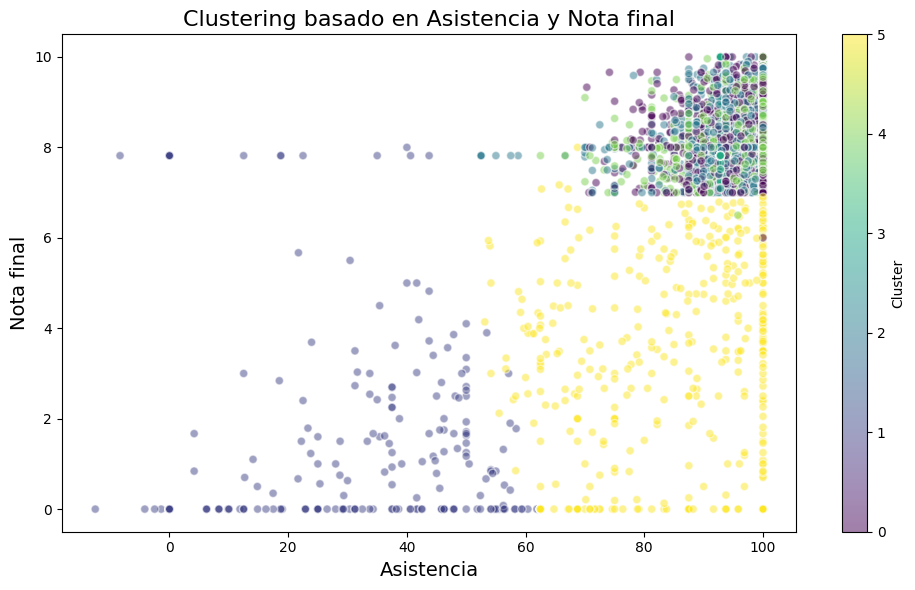

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Asistencia'], df['Nota final'], c=df['Cluster'], cmap='viridis', alpha=0.5, edgecolors='w')
plt.title("Clustering basado en Asistencia y Nota final", fontsize=16)
plt.xlabel("Asistencia", fontsize=14)
plt.ylabel("Nota final", fontsize=14)
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()


## 5. Análisis de Resultados de Clustering

Ahora puedes analizar cada cluster:

In [ ]:
cluster_summary = df.groupby('Cluster').agg({
    'Asistencia': 'mean',
    'Nota final': 'mean',
    'Carrera': lambda x: x.mode()[0],  # Carrera más frecuente
    'Nivel': lambda x: x.mode()[0],    # Nivel más frecuente
    'Estado': lambda x: x.mode()[0],   # Estado más frecuente
    'Tipo Ingreso': lambda x: x.mode()[0]  # Tipo Ingreso más frecuente
}).reset_index()

print(cluster_summary)


   Cluster  Asistencia  Nota final  Carrera  Nivel  Estado  Tipo Ingreso
0        0   97.141447    8.495011       11      4       0             1
1        1   25.808358    1.181882        4      1       2             1
2        2   97.031349    8.617852       11      1       0             1
3        3   92.818492    7.918868       14      1       0             0
4        4   97.061763    8.425758        8      1       0             1
5        5   85.154353    3.657342        4      1       2             1


## Interpretación de Cada Cluster

**Cluster 0: Alto Rendimiento Académico**

Asistencia Alta: La asistencia promedio es 97.14, indicando un alto nivel de participación en las clases.

Nota Final Alta: La nota final promedio es 8.50, lo que refleja un buen desempeño académico.

Carrera: Carrera más frecuente es 11.

Nivel: Nivel promedio es 4.

Estado: El estado más frecuente es 0.

Tipo de Ingreso: Tipo de ingreso más frecuente es 1.

**Cluster 1: Bajo Rendimiento Académico**

Asistencia Baja: La asistencia promedio es 25.81, lo que sugiere una baja participación en las clases.

Nota Final Baja: La nota final promedio es 1.18, indicando un rendimiento académico bajo.

Carrera: Carrera más frecuente es 4.

Nivel: Nivel promedio es 1.

Estado: El estado más frecuente es 2.

Tipo de Ingreso: Tipo de ingreso más frecuente es 1.

**Cluster 2: Alto Rendimiento en Nivel Inicial**

Asistencia Alta: La asistencia promedio es 97.03, indicando un alto nivel de participación.

Nota Final Alta: La nota final promedio es 8.62, lo que refleja un buen desempeño académico.

Carrera: Carrera más frecuente es 11.

Nivel: Nivel promedio es 1.

Estado: El estado más frecuente es 0.

Tipo de Ingreso: Tipo de ingreso más frecuente es 1.

**Cluster 3: Rendimiento Moderado**

Asistencia Alta: La asistencia promedio es 92.82, con un buen nivel de participación.

Nota Final Moderada: La nota final promedio es 7.92, lo que sugiere un rendimiento académico moderado.

Carrera: Carrera más frecuente es 14.

Nivel: Nivel promedio es 1.

Estado: El estado más frecuente es 0.

Tipo de Ingreso: Tipo de ingreso más frecuente es 0.

**Cluster 4: Alto Rendimiento en Nivel Inicial**

Asistencia Alta: La asistencia promedio es 97.06, indicando un alto nivel de participación.

Nota Final Alta: La nota final promedio es 8.43, lo que refleja un buen desempeño académico.

Carrera: Carrera más frecuente es 8.

Nivel: Nivel promedio es 1
.
Estado: El estado más frecuente es 0.

Tipo de Ingreso: Tipo de ingreso más frecuente es 1.

**Cluster 5: Bajo Rendimiento en Nivel Inicial**

Asistencia Moderada: La asistencia promedio es 85.15.

Nota Final Baja: La nota final promedio es 3.66, indicando un rendimiento académico bajo.

Carrera: Carrera más frecuente es 4.

Nivel: Nivel promedio es 1.

Estado: El estado más frecuente es 2.

Tipo de Ingreso: Tipo de ingreso más frecuente es 1.

**Conclusiones Generales**

Cluster 0: Este grupo tiene una alta asistencia y buen rendimiento académico. Los estudiantes en este cluster tienen un buen nivel de participación y desempeño, lo que sugiere que están bien integrados y comprometidos con su educación.

Cluster 1: Con baja asistencia y bajo rendimiento académico, este grupo necesita atención especial para mejorar su participación y desempeño. Considerar estrategias para aumentar la asistencia y apoyo académico.

Cluster 2: Similar al Cluster 0 en términos de alta asistencia y buen rendimiento, pero en un nivel inicial. Este grupo también muestra un fuerte compromiso académico desde el principio.

Cluster 3: Aunque la asistencia es alta, el rendimiento académico es moderado. Los estudiantes en este grupo podrían estar enfrentando desafíos académicos y podrían beneficiarse de apoyo adicional.

Cluster 4: Este grupo muestra alta asistencia y buen rendimiento académico en un nivel inicial, similar a los Clusters 0 y 2, pero con una carrera diferente. Los estudiantes están bien comprometidos y tienen un buen desempeño.

Cluster 5: Con moderada asistencia y bajo rendimiento académico, este grupo también está en un nivel inicial. Podría beneficiarse de apoyo adicional para mejorar tanto la participación como el rendimiento académico.

**Estrategias de Marketing:**

Cluster 0: Mantener el buen trabajo que están haciendo. Ofrecer oportunidades adicionales para que sigan mejorando.

Cluster 1: Trabajar en aumentar la asistencia y el rendimiento. Considerar darles más apoyo y motivación para mejorar.

Cluster 2: Seguir aprovechando el buen rendimiento de estos estudiantes. Ofrecer recursos y oportunidades para que continúen destacando.

Cluster 3: Ayudar a estos estudiantes a superar los desafíos académicos. Proporcionar apoyo adicional para mejorar sus calificaciones.

Cluster 4: Fomentar el alto rendimiento desde el principio. Ofrecer cursos y recursos para mantener su buen desempeño.

Cluster 5: Implementar estrategias para aumentar la asistencia y el rendimiento. Ofrecer apoyo adicional para motivar a los estudiantes y mejorar sus resultados.